In [1]:
import numpy as np
import pandas as pd
import os
import random
import math
import tqdm
import copy
import ast
from itertools import chain, combinations
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from typing import Optional

In [2]:
# disable ConvergenceWarnings
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [3]:
# PRNG seed for reproducibility
random_seed = 42
np.random.seed(random_seed)

### Loading the dataset

In [4]:
file_path = 'spambase/spambase.data'  # Adjust the path as needed
df = pd.read_csv(file_path, header=None)

### Preprocessing

In [5]:
X = df.iloc[:, :-1].to_numpy()
y = df.iloc[:, -1].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### The model accuracy without clients:

In [6]:
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

acc = model.score(X_test, y_test)
print(acc)

0.9196525515743756


### Federated Learning: 
#### Spliting

In [7]:
def split_data_equal(X: np.ndarray, y: np.ndarray, n_clients: int, shuffle: bool=False):

  if shuffle:
    idx = np.random.permutation(X.shape[0])
    X = X[idx]
    y = y[idx]

  n_entries_per_client = X.shape[0] // n_clients
  partitions = []
  for i in range(n_clients):
    start = i*n_entries_per_client
    end = (i+1)*n_entries_per_client
    X_i = X[start:end]
    y_i = y[start:end]
    partitions.append((X_i, y_i))
  partitions[-1] = (X[start:], y[start:])

  return partitions

In [8]:
n_clients = 10
client_accs = []
client_models = []
partitions = split_data_equal(X_train, y_train, n_clients, shuffle=True)

for i in range(n_clients):
  X_i, y_i = partitions[i]
  model = LogisticRegression(random_state=random_seed)
  model.fit(X_i, y_i)
  client_models.append(model)
  client_accs.append(model.score(X_test, y_test))

#### Aggregate Models

In [9]:
def aggregate_lr_models(models: list):

  aggregated_model = LogisticRegression(random_state=random_seed)
  aggregated_model.coef_ = np.mean([model.coef_ for model in models], axis=0)
  aggregated_model.intercept_ = np.mean([model.intercept_ for model in models], axis=0)
  aggregated_model.classes_ = models[0].classes_

  return aggregated_model


### FL without Data Corruption(All Clients Join)

In [10]:
# Convert the generator into a list
models_and_accs = list(zip(client_models, client_accs))

# Extract models and pass them to the aggregation function
federated_model = aggregate_lr_models([model for model, acc in models_and_accs])

# Evaluate the aggregated model
acc = federated_model.score(X_test, y_test)
print(f"Federated model's accuracy: {acc:.4f}")


Federated model's accuracy: 0.9327


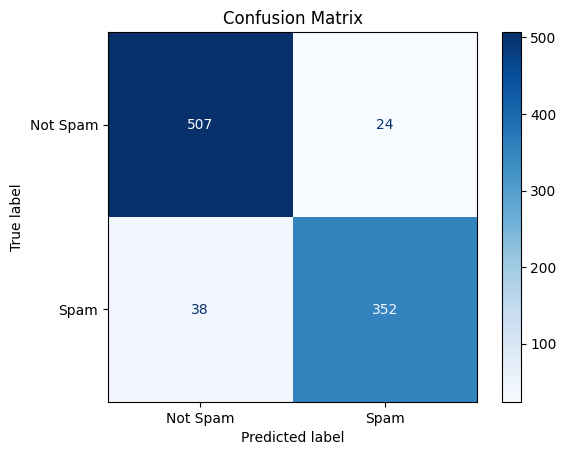

In [11]:
y_pred = federated_model.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Spam", "Spam"])
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.show()

#### Powerset section for 10 clients -  Summary: 

It includes the following components:

#### 1. **Data Corruption Functions**
- **`corrupt_data`**: Randomly corrupts rows in a dataset by either `adding noise` or setting features to `NaN`, with a probability of corruption.

#### 2. **Client Data Corruption**
- **`corrupt_clients`**: Selects a specified number of clients randomly and applies one of the data corruption functions to their datasets.

#### 3. **Federated Learning Simulation**
- **`run_federated_learning`**: Simulates a federated learning setup by:
  - Training individual models for each client.
  - Aggregating models from subsets of clients to evaluate overall performance.
  - Exploring all possible combinations of client participation and their effect on the final model’s accuracy.


- Outputs results as a detailed dataframe showing the aggregated and individual client accuracies.


In [12]:
def corrupt_data(X: np.ndarray, y: np.ndarray, corruption_prob: float = 0.8, nan_prob: float = 0.5, noise_std: Optional[float] = None):
    if noise_std is None:
        noise_std = 0.1
        
    # NOTE: @marchiorot: in this case, you should make a copy to avoid overwriting the original DataFrame
    X = X.copy()

    mask = np.random.rand(X.shape[0]) < corruption_prob
    mask_nan = mask & (np.random.rand(X.shape[0]) < nan_prob)
    mask_noise = mask & (~mask_nan)

    X += mask_noise[:, None] * np.random.randn(X.shape[0], X.shape[1]) * 5
    X[np.argwhere(mask_nan)] = np.nan
    
    return X, y


# Function to corrupt data for specific clients
def corrupt_clients(f,partitions, n_corrupt_clients):
    corrupt_client_indices = np.random.choice(len(partitions) - 1, size=n_corrupt_clients, replace=False) + 1
    for idx in corrupt_client_indices:
        X_i, y_i = partitions[idx]
        X_i_corrupted, y_i_corrupted = f(X_i.copy(), y_i.copy())
        partitions[idx] = (X_i_corrupted, y_i_corrupted)
    return partitions, corrupt_client_indices

In [13]:
# Split data among clients
partitions = split_data_equal(X_train, y_train, n_clients=n_clients, shuffle=True)

In [14]:
def save_results_to_csv(df_results, n_corrupt_clients):
    filename = f"results_with_{n_corrupt_clients}_corrupted_clients.csv"
    df_results.to_csv(filename, index=False)
    print(f"Results saved to {filename}")

In [15]:
def train_client_models(partitions, random_seed, X_test, y_test, max_iter):
    client_models = []
    client_global_accuracies = []
    client_local_accuracies = []
    for X_i, y_i in partitions:
        # Remove rows with NaN values
        nan_mask = ~np.isnan(X_i).any(axis=1)
        X_i_clean = X_i[nan_mask]
        y_i_clean = y_i[nan_mask]
        if len(y_i_clean) == 0:
            # No data to train on after cleaning
            client_models.append(None)
            client_global_accuracies.append(None)
            client_local_accuracies.append(None)
            continue
        model = LogisticRegression(random_state=random_seed, max_iter=max_iter)
        try:
            model.fit(X_i_clean, y_i_clean)
            client_models.append(model)

            acc_local = model.score(X_i_clean, y_i_clean)
            client_local_accuracies.append(acc_local)

            # Compute local accuracy on global test set
            local_acc = model.score(X_test, y_test)
            client_global_accuracies.append(local_acc)

        except Exception as e:
            # Model training failed
            client_models.append(None)
            client_global_accuracies.append(None)
            client_local_accuracies.append(None)
    return client_models, client_local_accuracies, client_global_accuracies

def run_federated_learning(
    partitions,
    n_clients=10,
    n_corrupt_clients=None,
    random_seed=None,
    shuffle=True,
    max_iter=10,
):

    # Make a deep copy of partitions to prevent in-place modification
    partitions_copy = copy.deepcopy(partitions)

    # Corrupt data for a random number of clients
    if n_corrupt_clients is None:
        n_corrupt_clients = np.random.randint(1, n_clients + 1)  # Randomly choose how many clients to corrupt

    partitions_corrupted, corrupt_client_indices = corrupt_clients(corrupt_data, partitions_copy, n_corrupt_clients)

    # Train models for each client and compute accuracies
    client_models, client_local_accuracies, client_global_accuracies = train_client_models(
        partitions_corrupted, random_seed, X_test, y_test, max_iter
    )

    # Generate all possible combinations of clients represented as binary strings
    results = []
    n_combinations = 2 ** n_clients
    for i in range(1, n_combinations):
        bin_str = format(i, f'0{n_clients}b')
        # Determine which clients are included in this combination
        client_indices = [j for j in range(n_clients) if bin_str[n_clients - 1 - j] == '1']
        included_models = [client_models[j] for j in client_indices if client_models[j] is not None]

        if not included_models:
            # Skip combinations where no valid models are available
            continue

        # Aggregate models
        federated_model = aggregate_lr_models(included_models)
        agg_acc = federated_model.score(X_test, y_test)

        # Prepare the row data
        row = {'Combination': bin_str, 'Clients': [client + 1 for client in client_indices], 'Global Accuracy': agg_acc}

        # Add global accuracies for each client
        for j in range(n_clients):
            acc = client_global_accuracies[j] if client_global_accuracies[j] is not None else np.nan
            column_name = f"Client {j + 1} Accuracy"
            if j in corrupt_client_indices:
                column_name += " (corrupted client)"
            row[column_name] = acc

        results.append(row)

    df_results = pd.DataFrame(results)

    print(f"Corrupted client indices: {np.array(corrupt_client_indices) + 1}")

    # Save results to CSV
    save_results_to_csv(df_results, n_corrupt_clients)

    return df_results, corrupt_client_indices, client_local_accuracies, client_global_accuracies


#### Run with different number of corrpted clients

### One Client

In [15]:
# Call the function
df_results, corrupt_client_indices , client_local_accuracies , client_global_accuracies = run_federated_learning(
    partitions=partitions,
    n_clients=n_clients,
    n_corrupt_clients=1,  
    random_seed=42,
    shuffle=True,
    max_iter=10
)

Corrupted client indices: [9]
Results saved to results_with_1_corrupted_clients.csv


In [16]:
df_top_results = df_results.sort_values(by='Global Accuracy', ascending=False).head(5)
df_top_results

,Combination,Clients,Global Accuracy,Client 1 Accuracy,Client 2 Accuracy,Client 3 Accuracy,Client 4 Accuracy,Client 5 Accuracy,Client 6 Accuracy,Client 7 Accuracy,Client 8 Accuracy,Client 9 Accuracy (corrupted client),Client 10 Accuracy
676,1010100101,"[1, 3, 6, 8, 10]",0.935939,0.903366,0.893594,0.892508,0.890337,0.909881,0.916395,0.900109,0.908795,0.669924,0.917481
680,1010101001,"[1, 4, 6, 8, 10]",0.934853,0.903366,0.893594,0.892508,0.890337,0.909881,0.916395,0.900109,0.908795,0.669924,0.917481
565,1000110110,"[2, 3, 5, 6, 10]",0.934853,0.903366,0.893594,0.892508,0.890337,0.909881,0.916395,0.900109,0.908795,0.669924,0.917481
550,1000100111,"[1, 2, 3, 6, 10]",0.933768,0.903366,0.893594,0.892508,0.890337,0.909881,0.916395,0.900109,0.908795,0.669924,0.917481
688,1010110001,"[1, 5, 6, 8, 10]",0.933768,0.903366,0.893594,0.892508,0.890337,0.909881,0.916395,0.900109,0.908795,0.669924,0.917481


In [17]:
from Functions import find_best_worst_clients, calculate_global_accuracy, find_best_global_accuracy_per_client
from Functions import find_worst_global_accuracy_per_client, calculate_client_contributions, visualize_client_contributions , compute_and_visualize_shapley_values

In [18]:
best_client, worst_client = find_best_worst_clients(client_local_accuracies)
mean_with_best, mean_without_best = calculate_global_accuracy(df_results, best_client)
mean_with_worst, mean_without_worst = calculate_global_accuracy(df_results, worst_client)

Best Client: 3, Worst Client: 9
Statistics of Global Accuracy with Client 3:
  Mean: 0.9205644340390879
  Std Dev: 0.007805277719963687
  Min: 0.8838219326818675
  Max: 0.9359391965255157

Statistics of Global Accuracy without Client 3:
  Mean: 0.9192977088207109
  Std Dev: 0.014095297195401231
  Min: 0.6699239956568946
  Max: 0.9348534201954397
Statistics of Global Accuracy with Client 9:
  Mean: 0.9171692623507057
  Std Dev: 0.014031963273077819
  Min: 0.6699239956568946
  Max: 0.9337676438653637

Statistics of Global Accuracy without Client 9:
  Mean: 0.9226995246806946
  Std Dev: 0.006921340052456156
  Min: 0.8903365906623235
  Max: 0.9359391965255157


In [19]:
df_best_global_per_client = find_best_global_accuracy_per_client(df_results)
df_worst_global_per_client = find_worst_global_accuracy_per_client(df_results)

Best Global Accuracy per Client:
    Client  Best Global Accuracy           Best Combination
0       1              0.935939           [1, 3, 6, 8, 10]
1       2              0.934853           [2, 3, 5, 6, 10]
2       3              0.935939           [1, 3, 6, 8, 10]
3       4              0.934853           [1, 4, 6, 8, 10]
4       5              0.934853           [2, 3, 5, 6, 10]
5       6              0.935939           [1, 3, 6, 8, 10]
6       7              0.933768  [1, 3, 5, 6, 7, 8, 9, 10]
7       8              0.935939           [1, 3, 6, 8, 10]
8       9              0.933768           [1, 6, 8, 9, 10]
9      10              0.935939           [1, 3, 6, 8, 10]
Worst Global Accuracy per Client:
    Client  Worst Global Accuracy Worst Combination
0       1               0.881650            [1, 9]
1       2               0.872964            [2, 9]
2       3               0.883822            [3, 9]
3       4               0.875136            [4, 9]
4       5               0.8

Client Contributions:
    Client  Frequency
2       6         10
4      10         10
0       1          8
1       3          8
3       8          8
6       5          3
5       2          2
9       9          2
7       4          1
8       7          1


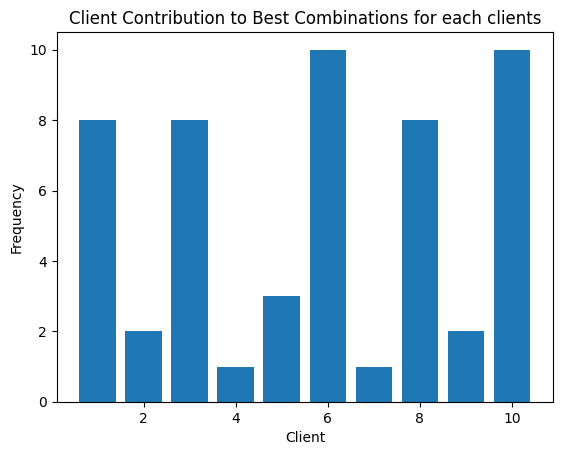

Client Contributions:
    Client  Frequency
1       9         10
4       4          2
7       7          2
0       1          1
2       2          1
3       3          1
5       5          1
6       6          1
8       8          1
9      10          1


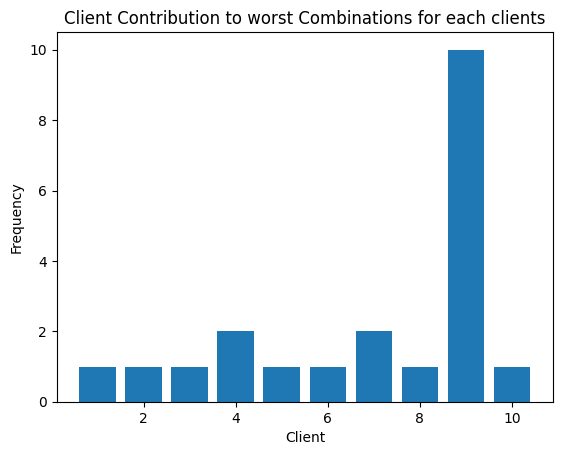

In [21]:
visualize_client_contributions(calculate_client_contributions(df_results, best=True), "Client Contribution to Best Combinations for each clients")
visualize_client_contributions(calculate_client_contributions(df_results, best=False), "Client Contribution to worst Combinations for each clients")

In [22]:
from Nash import find_nash_equilibria_v2

In [24]:
nash_df = find_nash_equilibria_v2(df_results)
nash_df

,Combination,Clients,Global Accuracy
0,0100000000,[9],0.669924
1,1111111111,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",0.926167


### Three Clients

In [25]:
# Call the function
df_results, corrupt_client_indices , client_local_accuracies , client_global_accuracies = run_federated_learning(
    partitions=partitions,
    n_clients=n_clients,
    n_corrupt_clients=3,  
    random_seed=42,
    shuffle=True,
    max_iter=10
)

Corrupted client indices: [5 9 3]
Results saved to results_with_3_corrupted_clients.csv


In [ ]:
df_top_results = df_results.sort_values(by='Global Accuracy', ascending=False).head(5)
df_top_results

In [26]:
nash_df = find_nash_equilibria_v2(df_results)
nash_df

,Combination,Clients,Global Accuracy
0,0100010000,"[5, 9]",0.752443
1,1111111111,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",0.922910


### Four Clients

In [86]:
# Call the function
df_results, corrupt_client_indices , client_local_accuracies , client_global_accuracies = run_federated_learning(
    partitions=partitions,
    n_clients=n_clients,
    n_corrupt_clients=4,  
    random_seed=42,
    shuffle=True,
    max_iter=10
)

Corrupted client indices: [10  5  4  8]
Results saved to results_with_4_corrupted_clients.csv


In [ ]:
df_top_results = df_results.sort_values(by='Global Accuracy', ascending=False).head(5)
df_top_results

In [87]:
nash_df = find_nash_equilibria_v2(df_results)
nash_df

,Combination,Clients,Global Accuracy
0,1010011000,"[4, 5, 8, 10]",0.741585
1,1110011110,"[2, 3, 4, 5, 8, 9, 10]",0.900109
2,1111011111,"[1, 2, 3, 4, 5, 7, 8, 9, 10]",0.908795


### Five Clients

In [27]:
# Call the function
df_results, corrupt_client_indices , client_local_accuracies , client_global_accuracies = run_federated_learning(
    partitions=partitions,
    n_clients=n_clients,
    n_corrupt_clients=5,  
    random_seed=42,
    shuffle=True,
    max_iter=10
)

Corrupted client indices: [7 6 3 4 5]
Results saved to results_with_5_corrupted_clients.csv


In [ ]:
df_top_results = df_results.sort_values(by='Global Accuracy', ascending=False).head(5)
df_top_results

In [28]:
best_client, worst_client = find_best_worst_clients(client_local_accuracies)
mean_with_best, mean_without_best = calculate_global_accuracy(df_results, best_client)
mean_with_worst, mean_without_worst = calculate_global_accuracy(df_results, worst_client)

Best Client: 8, Worst Client: 7
Statistics of Global Accuracy with Client 8:
  Mean: 0.9056434921281216
  Std Dev: 0.013221880512475014
  Min: 0.8338762214983714
  Max: 0.9294245385450597

Statistics of Global Accuracy without Client 8:
  Mean: 0.8835159604870908
  Std Dev: 0.047596237482862534
  Min: 0.6286644951140065
  Max: 0.9261672095548317
Statistics of Global Accuracy with Client 7:
  Mean: 0.8896261706026058
  Std Dev: 0.039493214081787284
  Min: 0.6286644951140065
  Max: 0.9261672095548317

Statistics of Global Accuracy without Client 7:
  Mean: 0.8995646270645156
  Std Dev: 0.0327687728669729
  Min: 0.6992399565689468
  Max: 0.9294245385450597


In [29]:
df_best_global_per_client = find_best_global_accuracy_per_client(df_results)
df_worst_global_per_client = find_worst_global_accuracy_per_client(df_results)

Best Global Accuracy per Client:
    Client  Best Global Accuracy           Best Combination
0       1              0.929425           [1, 2, 6, 8, 10]
1       2              0.929425           [1, 2, 6, 8, 10]
2       3              0.928339           [1, 2, 3, 8, 10]
3       4              0.922910        [1, 2, 3, 4, 8, 10]
4       5              0.926167                 [1, 5, 10]
5       6              0.929425           [1, 2, 6, 8, 10]
6       7              0.926167        [1, 2, 3, 7, 8, 10]
7       8              0.929425           [1, 2, 6, 8, 10]
8       9              0.925081  [1, 2, 3, 5, 6, 8, 9, 10]
9      10              0.929425           [1, 2, 6, 8, 10]
Worst Global Accuracy per Client:
    Client  Worst Global Accuracy   Worst Combination
0       1               0.844734  [1, 3, 4, 5, 6, 7]
1       2               0.820847  [2, 3, 4, 5, 6, 7]
2       3               0.659066              [3, 7]
3       4               0.672096              [4, 7]
4       5        

Client Contributions:
    Client  Frequency
0       1         10
4      10         10
1       2          9
3       8          9
2       6          6
5       3          4
7       5          2
6       4          1
8       7          1
9       9          1


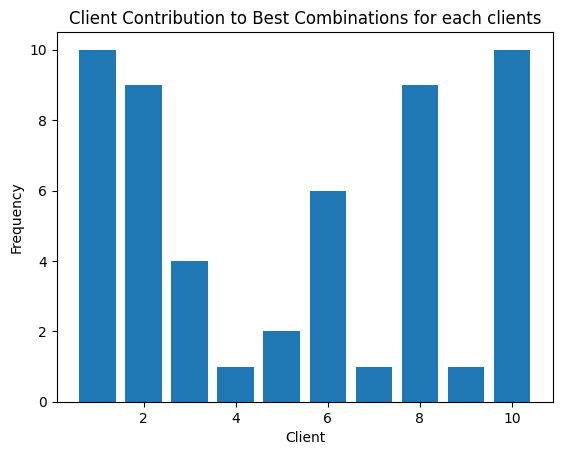

Client Contributions:
    Client  Frequency
5       7         10
1       3          7
2       4          7
3       5          6
4       6          3
0       1          1
6       2          1
7       8          1
8       9          1
9      10          1


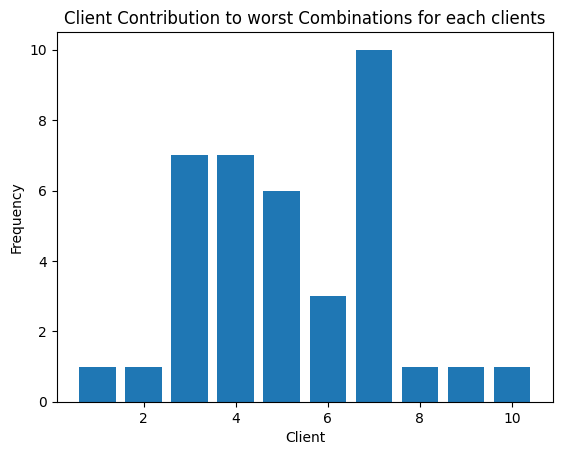

In [31]:
visualize_client_contributions(calculate_client_contributions(df_results, best=True), "Client Contribution to Best Combinations for each clients")
visualize_client_contributions(calculate_client_contributions(df_results, best=False), "Client Contribution to worst Combinations for each clients")

In [32]:
nash_df = find_nash_equilibria_v2(df_results)
nash_df

,Combination,Clients,Global Accuracy
0,0001000000,[7],0.628664
1,0001011100,"[3, 4, 5, 7]",0.711183


### Six Clients

In [33]:
# Call the function
df_results, corrupt_client_indices , client_local_accuracies , client_global_accuracies = run_federated_learning(
    partitions=partitions,
    n_clients=n_clients,
    n_corrupt_clients=6,  
    random_seed=42,
    shuffle=True,
    max_iter=10
)

Corrupted client indices: [5 6 4 3 8 7]
Results saved to results_with_6_corrupted_clients.csv


In [ ]:
df_top_results = df_results.sort_values(by='Global Accuracy', ascending=False).head(5)
df_top_results

In [34]:
nash_df = find_nash_equilibria_v2(df_results)
nash_df

,Combination,Clients,Global Accuracy
0,0001000000,[7],0.685125
1,0001011000,"[4, 5, 7]",0.731813


In [35]:
best_client, worst_client = find_best_worst_clients(client_local_accuracies)
mean_with_best, mean_without_best = calculate_global_accuracy(df_results, best_client)
mean_with_worst, mean_without_worst = calculate_global_accuracy(df_results, worst_client)

Best Client: 10, Worst Client: 7
Statistics of Global Accuracy with Client 10:
  Mean: 0.9026703311617806
  Std Dev: 0.010633389373301029
  Min: 0.8664495114006515
  Max: 0.9261672095548317

Statistics of Global Accuracy without Client 10:
  Mean: 0.8667703572437855
  Std Dev: 0.04231672753478505
  Min: 0.6851248642779587
  Max: 0.9142236699239956
Statistics of Global Accuracy with Client 7:
  Mean: 0.8794448968512487
  Std Dev: 0.037330024545953806
  Min: 0.6851248642779587
  Max: 0.9196525515743756

Statistics of Global Accuracy without Client 7:
  Mean: 0.8900412425020876
  Std Dev: 0.03313193883371188
  Min: 0.7198697068403909
  Max: 0.9261672095548317


In [37]:
result = compute_and_visualize_shapley_values(
    df_results,
    client_global_accuracies,
    n_clients=10
)

      Client  Local Accuracy  Normalized Shapley Value
9  Client 10        0.917481                  0.142236
0   Client 1        0.903366                  0.134162
1   Client 2        0.893594                  0.129080
8   Client 9        0.883822                  0.116562
2   Client 3        0.800217                  0.091634
7   Client 8        0.783931                  0.087645
5   Client 6        0.755700                  0.082260
3   Client 4        0.725299                  0.076852
4   Client 5        0.719870                  0.074332
6   Client 7        0.685125                  0.065238


NameError: name 'sns' is not defined

<Figure size 1000x600 with 0 Axes>

### Seven Clients

In [53]:
# Call the function
df_results, corrupt_client_indices , client_local_accuracies , client_global_accuracies = run_federated_learning(
    partitions=partitions,
    n_clients=n_clients,
    n_corrupt_clients=7,  
    random_seed=42,
    shuffle=True,
    max_iter=10
)

Corrupted client indices: [ 9  4  3 10  6  7  5]
Results saved to results_with_7_corrupted_clients.csv


In [ ]:
df_top_results = df_results.sort_values(by='Global Accuracy', ascending=False).head(5)
df_top_results

In [54]:
nash_df = find_nash_equilibria_v2(df_results)
nash_df

,Combination,Clients,Global Accuracy
0,1101111000,"[4, 5, 6, 7, 9, 10]",0.780673


### Nine Clients

In [71]:
# Call the function
df_results, corrupt_client_indices , client_local_accuracies , client_global_accuracies = run_federated_learning(
    partitions=partitions,
    n_clients=n_clients,
    n_corrupt_clients=9,  
    random_seed=42,
    shuffle=True,
    max_iter=10
)

Corrupted client indices: [ 3  5  9  8  2 10  4  7  6]
Results saved to results_with_9_corrupted_clients.csv


In [ ]:
df_top_results = df_results.sort_values(by='Global Accuracy', ascending=False).head(5)
df_top_results

In [ ]:
best_client, worst_client = find_best_worst_clients(client_local_accuracies)
mean_with_best, mean_without_best = calculate_global_accuracy(df_results, best_client)
mean_with_worst, mean_without_worst = calculate_global_accuracy(df_results, worst_client)
df_best_global_per_client = find_best_global_accuracy_per_client(df_results)
df_worst_global_per_client = find_worst_global_accuracy_per_client(df_results)
visualize_client_contributions(best_contributions, "Client Contribution to Best Combinations for each clients")
visualize_client_contributions(worst_contributions, "Client Contribution to worst Combinations for each clients")

In [72]:
nash_df = find_nash_equilibria_v2(df_results)
nash_df

,Combination,Clients,Global Accuracy
0,0010010100,"[3, 5, 8]",0.723127
1,0011111110,"[2, 3, 4, 5, 6, 7, 8]",0.764387
